In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import ufss

In [6]:
site_energies = [0,0]
site_couplings = [0.5]
dipoles = [[1,0,0],
           [0,1,0]]
trunc_size = 3
d = 0.1
open_folder = 'DiabaticLindblad_test'
os.makedirs(open_folder,exist_ok=True)

gamma_v = 0.05
gamma_d1 = 0.2
gamma_d2 = 0
gamma_r1 = 0
gamma_r2 = 0.05
DiabaticLindblad_bath = {
    'kT':1,
    'site_to_site_dephasing_gamma':gamma_d2,
    'site_to_site_relaxation_gamma':gamma_r2,
    'vibrational_gamma':gamma_v,
    'optical_dephasing_gamma':gamma_d1,
    'optical_relaxation_gamma':gamma_r1,
    'force_detailed_balance':False #if True, this will map onto secular Redfield 
}

vibrations = [{'displacement':d,'site_label':0,'omega_g':1},
              {'displacement':d,'site_label':1,'omega_g':1.0001}]

params = {
    'site_energies':site_energies,
    'site_couplings':site_couplings,
    'dipoles':dipoles,
    'truncation_size':trunc_size,
    'vibrations':vibrations,
    'bath':DiabaticLindblad_bath}

with open(os.path.join(open_folder,'simple_params.yaml'),'w+') as new_file:
    yaml.dump(params,new_file)
    
ufss.HLG.run(open_folder)
#ufss.HLG.convert(open_folder)

#pv = ufss.HLG.OpenPolymerVibrations(os.path.join(open_folder,'params.yaml'),
#                                                        mask_by_occupation_num=True,for_RKE=False)

In [14]:
tdpe = ufss.DensityMatrices(os.path.join(open_folder,'open'),detection_type='complex_polarization')
# set electric field shape
M = 25 #should be odd
Delta = 10
t = np.linspace(-Delta/2,Delta/2,num=M)
pulse_shape = ufss.efield_shapes.gaussian
sigma = 1
ef = pulse_shape(t,sigma)
tdpe.set_efields([t,t,t,t],[ef,ef,ef,ef],[0,0,0,0],[(0,1),(1,0),(1,0)])
tdpe.set_polarization_sequence(['x','x','x','x'])
tdpe.set_t(gamma_d1/2,dt=1)

tau = tdpe.t[tdpe.t.size//2:]
T = np.arange(20)*np.pi/2

tdpe.set_pulse_delays([tau,T])

In [15]:
signal = tdpe.calculate_signal_all_delays()
#tdpe.save('TDPE',['tau','T'])

In [16]:
tdpe.calculation_time

18.780523777008057

In [17]:
wtau, ft_signal = ufss.signals.SignalProcessing.ft1D(tau,signal,axis=0)

2DPE signal at T = 0.00 $\omega_0^{-1}$


<IPython.core.display.Javascript object>


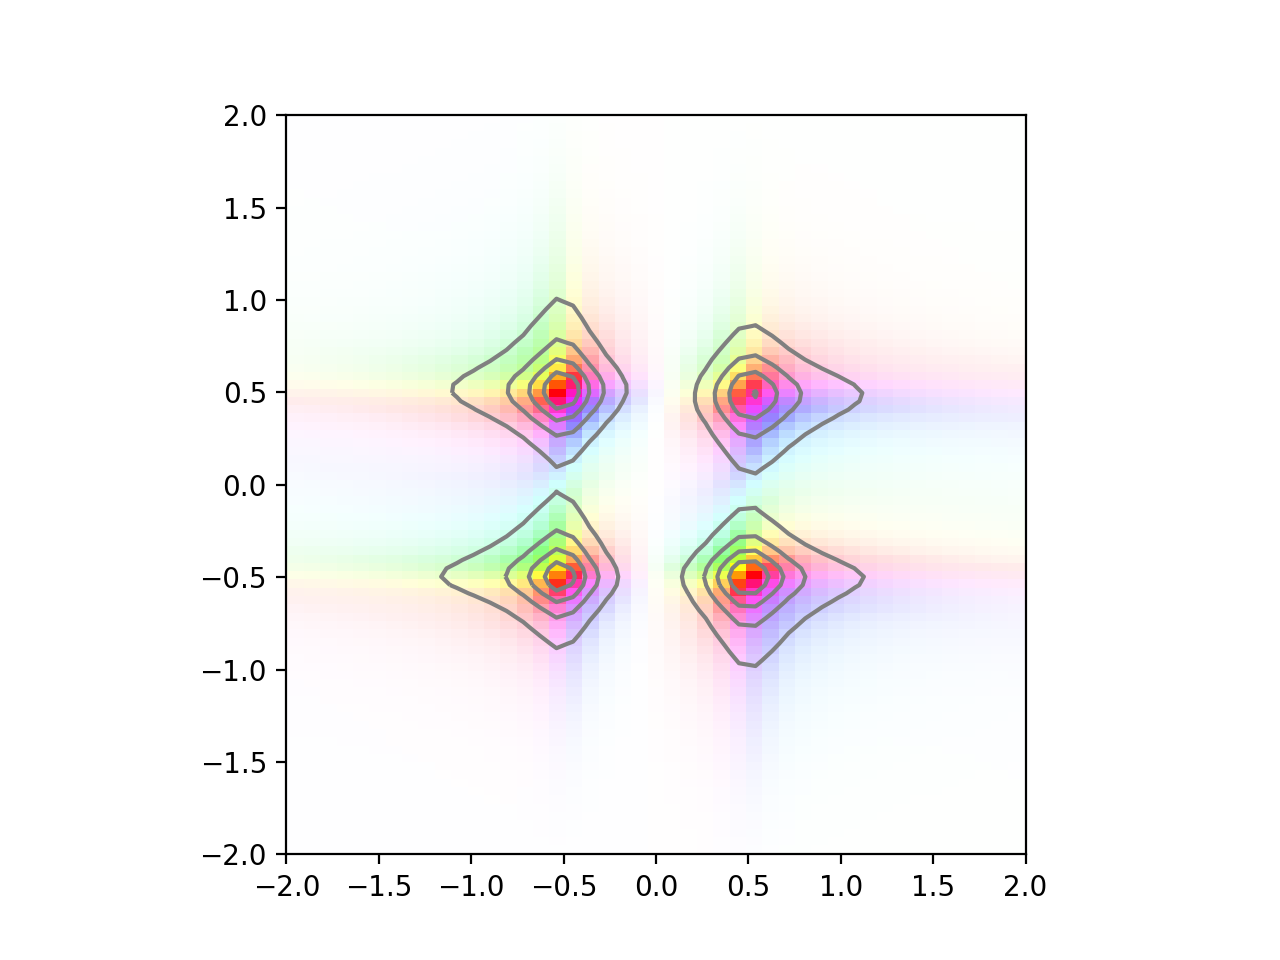

None


(-2, 2)

In [18]:
T_index = 0
print('2DPE signal at T = {:.2f} $\omega_0^{{-1}}$'.format(T[T_index]))
ufss.signals.plot2D(wtau,tdpe.w,ft_signal[:,T_index,:],part='complex',
                    contour_levels=[0.2,0.4,0.6,0.8],
                    contour_colormap=None,
                    contour_colors='gray',
                    colorbar=False)
plt.xlim([-2,2])
plt.ylim([-2,2])

TA signal


<IPython.core.display.Javascript object>


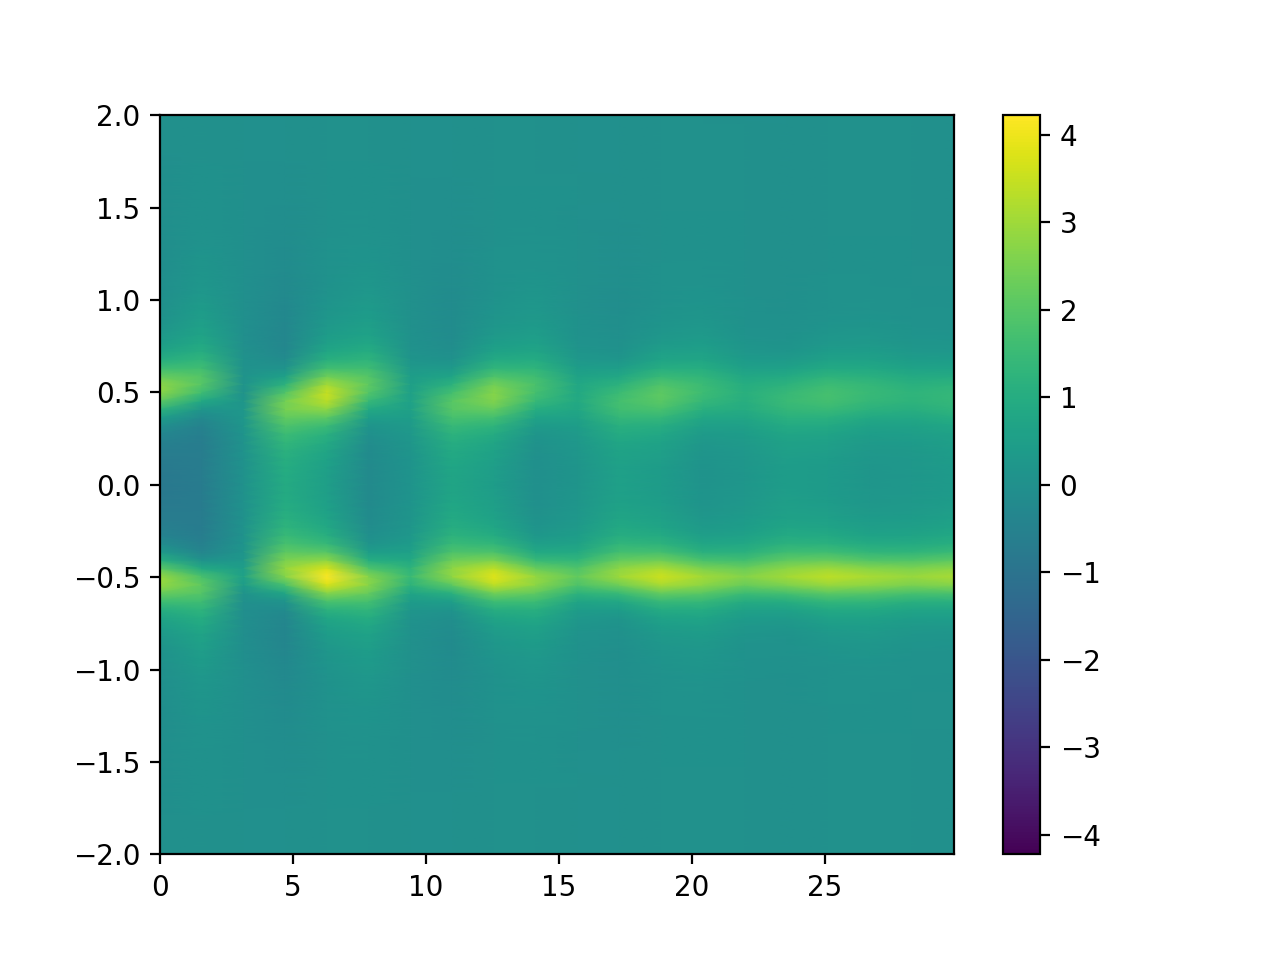

(-2, 2)

In [19]:
print('TA signal')
ufss.signals.plot2D(T,tdpe.w,signal[0,:,:],part='real',colormap='viridis')
#plt.xlim([-2,2])
plt.ylim([-2,2])

Integrated TA signal


<IPython.core.display.Javascript object>


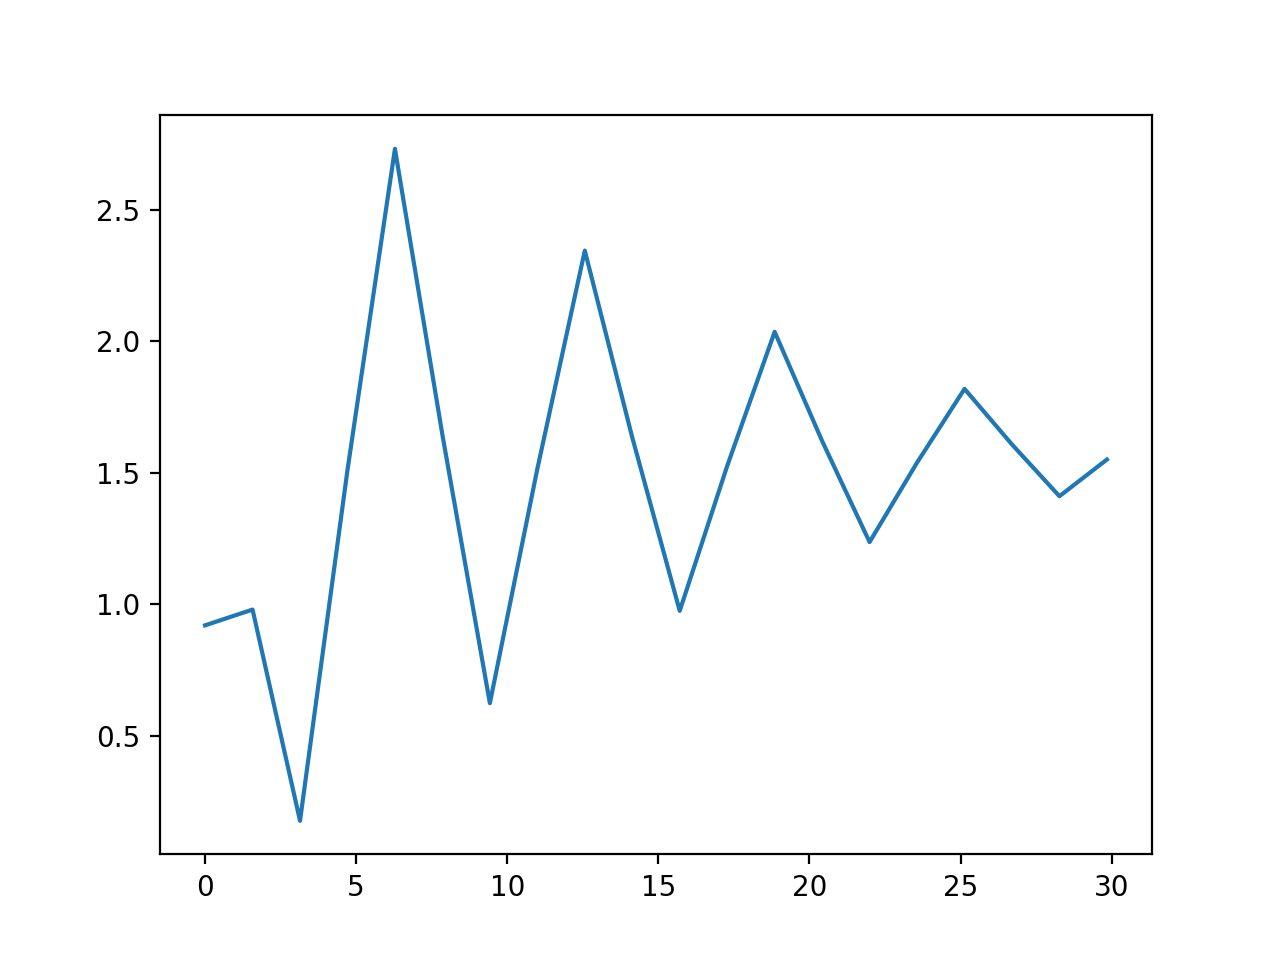

In [20]:
print('Integrated TA signal')
plt.figure()
plt.plot(T,np.trapz(np.real(signal[0,:,:]),x=tdpe.w,axis=-1))

In [11]:
# isotropic averaging is included for 4-wave mixing signals only
# all pulses have parallel polarization
iso = ufss.signals.FWMIsotropicAverage(tdpe,['x','x','x','x'])
sig_par = iso.averaged_signal(return_signal=True)

In [12]:
wtau, ft_sig_par = ufss.signals.SignalProcessing.ft1D(tau,sig_par,axis=0)

Isotropically Averaged 2DPE signal at T = 4.71 $\omega_0^{-1}$


<IPython.core.display.Javascript object>


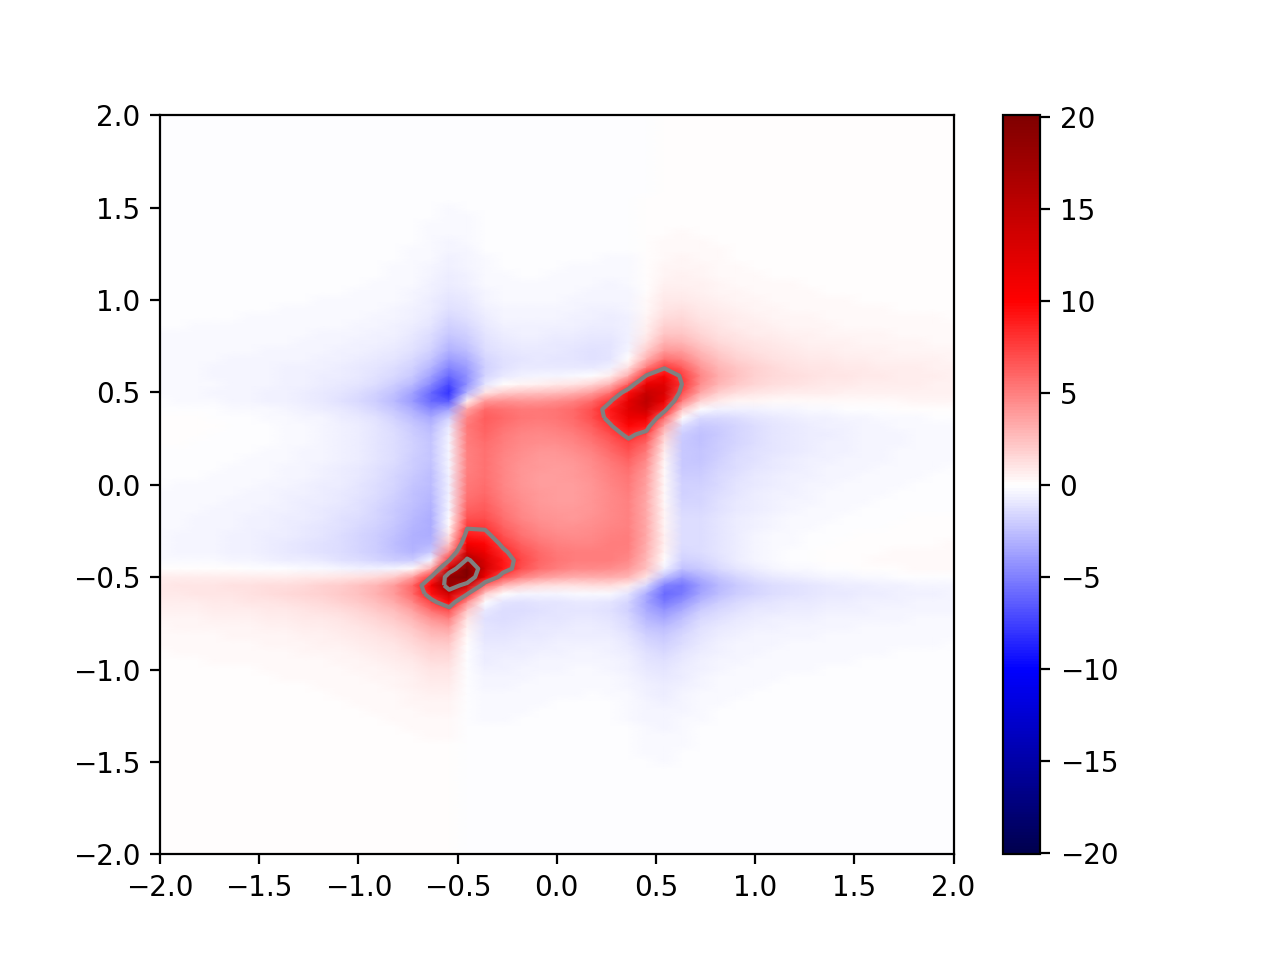

(-2, 2)

In [13]:
T_index = 3
print('Isotropically Averaged 2DPE signal at T = {:.2f} $\omega_0^{{-1}}$'.format(T[T_index]))
ufss.signals.plot2D(wtau,tdpe.w,ft_sig_par[:,T_index,:],part='real',
                    contour_levels=[-0.8,-0.4,0.4,0.8],
                   contour_colormap=None,
                   contour_colors='grey')
plt.xlim([-2,2])
plt.ylim([-2,2])

In [ ]:
# 3rd pulse and local oscillator are crossed with respect to first two pulses
iso = ufss.signals.FWMIsotropicAverage(tdpe,['x','x','y','y'])
sig_per = iso.averaged_signal(return_signal=True)

In [ ]:
wtau, ft_sig_per = ufss.signals.SignalProcessing.ft1D(tau,sig_per,axis=0)

In [ ]:
T_index = 1
print('Isotropically Averaged 2DPE signal at T = {:.2f} $\omega_0^{{-1}}$'.format(T[T_index]))
ufss.signals.plot2D(wtau,tdpe.w,ft_sig_per[:,T_index,:],part='complex',contour_levels=[0.2,0.4,0.6,0.8])
plt.xlim([-2,2])
plt.ylim([-2,2])